目前排版顺序：(4 classes)
EDA————数据预处理————inceptionV3（3个全连接层）50epoch 30%—————数据预处理————EfficientNet 50epoch 42%—————Vgg16 1st round 20epoch 30%————Vgg16 2st round 37epoch 70%————Binary classification

---

<h1 style="text-align: center;font-size: 40px;">Cataract Prediction using InceptionV3 and Vgg19</h1>

---

<h3>Dataset Information:</h3>
Ocular Disease Intelligent Recognition (ODIR) is a structured ophthalmic database of 5,000 patients with age, color fundus photographs from left and right eyes and doctors' diagnostic keywords from doctors.This dataset is meant to represent ‘‘real-life’’ set of patient information collected by Shanggong Medical Technology Co., Ltd. from different hospitals/medical centers in China. In these institutions, fundus images are captured by various cameras in the market, such as Canon, Zeiss and Kowa, resulting into varied image resolutions.Annotations were labeled by trained human readers with quality control management. They classify patient into eight labels including:

- Normal (N),
- Diabetes (D),
- Glaucoma (G),
- Cataract (C),
- Age related Macular Degeneration (A),
- Hypertension (H),
- Pathological Myopia (M),
- Other diseases/abnormalities (O)

- Here i'm going to make a model which is going to  predict an image is belongs to Normal or Cataract category!

# Import necessary libraries 導入必要的庫

In [ ]:
# Import necessary libraries
import numpy as np
import pandas as pd
import cv2
import random
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.utils import class_weight
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from mlxtend.plotting import plot_confusion_matrix
from google.colab import drive
import os  # Importing the os module
from imblearn.over_sampling import SMOTE  # For oversampling

# Data Loading and Preprocessing 數據加載與預處理

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# Define dataset directory and classes
dataset_dir = "/content/drive/MyDrive/archive(V2)/preprocessed_images"
classes = ['N', 'D', 'G', 'C', 'A', 'H', 'M', 'O']
class_to_label = {cls: idx for idx, cls in enumerate(classes)}

# Read data
df = pd.read_csv("/content/drive/MyDrive/archive(V2)/full_df.csv")

## Exploratory Data Analysis


In [ ]:
df_eda = df.copy()
df_eda.head()

In [ ]:
df_eda.info()

check duplicate value

In [ ]:
len(df_eda[df_eda.duplicated()])

check missing value

In [ ]:
df_eda.isnull().sum().sum()

In [ ]:
df_eda['labels'].value_counts()

In [ ]:
import re

df_eda["class"] = df_eda["labels"].apply(lambda x: " ".join(re.findall("[a-zA-Z]+", x)))

In [ ]:
labels_long = ["Normal", "Diabetes", "Glaucoma", "Cataract", "AMD", "Hypertension", "Myopia", "Other"]
labels_short = [ll[0] for ll in labels_long]

class_short2full = {
    ls: ll
    for ls, ll in zip(labels_short, labels_long)
}

class_dict = {class_ : i for i, class_ in enumerate(class_short2full.keys())}
class_dict_rev = {v: k for k, v in class_dict.items()}

NUM_CLASSES = len(class_dict)

In [ ]:
import matplotlib as mpl

SEED = 42

COLORS = {
    "fig_bg": "#f6f5f5",
    "plot_neut": "#ddbea9",
    "plot_text": "#343a40",

    "cmap_color_list": ["#001219", "#005F73", "#0A9396", "#94D2BD", "#E9D8A6",
                        "#EE9B00", "#CA6702", "#BB3E03", "#AE2012", "#9B2226"],

    "split": {
        "train": "#264653",
        "val": "#2a9d8f",
        "test": "#e9c46a"
    }
}

COLORS["class"] = {ls: c for ls, c in zip(class_short2full.keys(), COLORS["cmap_color_list"][:len(class_short2full.keys())])}
COLORS["cmap"] = mpl.colors.LinearSegmentedColormap.from_list("", COLORS["cmap_color_list"])
COLORS["cmap_pos"] = mpl.colors.LinearSegmentedColormap.from_list("", ["#F0F3F8", "#D1DBE9", "#A2B7D2", "#7493BC", "#6487B4", "#3D5A80"])

colors_class_list = list(COLORS["class"].values())

FONT_KW = {
    "plot_title" : {
        "fontname": "serif",
        "weight": "bold",
        "size": "25",
        "style": "normal"
    },
    "plot_title_small" : {
        "fontname": "serif",
        "weight": "bold",
        "size": "16",
        "style": "normal"
    },
    "plot_subtitle" : {
        "fontname": "serif",
        "weight": "bold",
        "size": "12",
        "style": "normal"
    },
    "subplot_title" : {
        "fontname": "serif",
        "weight": "bold",
        "size": "18",
        "style": "normal"
    },
    "subplot_title_small" : {
        "fontname": "serif",
        "weight": "bold",
        "size": "12",
        "style": "normal"
    },
    "plot_label" : {
        "fontname": "serif",
        "weight": "bold",
        "size": "16",
        "style": "normal"
    },
    "plot_label_small" : {
        "fontname": "serif",
        "weight": "bold",
        "size": "12",
        "style": "normal"
    },
    "plot_text" : {
        "fontname": "serif",
        "weight": "normal",
        "size": "12",
        "style": "normal"
    },
    "plot_text_small" : {
        "fontname": "serif",
        "weight": "normal",
        "size": "8",
        "style": "normal"
    },
}

In [ ]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(16, 6), dpi=70, gridspec_kw={"wspace": 0.5})

fig.patch.set_facecolor(COLORS["fig_bg"])

value_counts = df_eda["class"].value_counts().rename("num").to_frame()
value_counts["percent"] = value_counts / value_counts.sum()
value_counts.reindex(index=COLORS["class"].keys())

b1 = ax1.barh(value_counts.index, value_counts["percent"])

ax1.set_yticks(
    value_counts.index,
    [class_short2full[i] for i in value_counts.index],
    **FONT_KW["plot_label"], color=COLORS["plot_text"]
)
ax1.tick_params(axis="y", length=0)
ax1.set_title("Label-Based", loc="left", **FONT_KW["subplot_title"], color=COLORS["plot_text"], pad=30)
ax1.text(0, 8.2, "(Multi-class)", **FONT_KW["subplot_title_small"], color=COLORS["plot_text"])

ax1.bar_label(
    b1,
    labels=[str(val) + f"\n({str(np.round(100*pcnt,1))}%)" for val, pcnt in zip(value_counts["num"], value_counts["percent"])],
    color=COLORS["plot_text"],
    **FONT_KW["plot_text"]
)

ax1.set_facecolor(COLORS["fig_bg"])
for i in range(NUM_CLASSES):
    c = COLORS["class"][value_counts.index[i]]
    ax1.get_yticklabels()[i].set_color(c)
    b1[i].set_color(c)

ax1.axes.get_xaxis().set_visible(False)

for spine in ["bottom", "right", "top"]:
    ax1.spines[spine].set_visible(False)


value_count_diag = df_eda[labels_short].sum().rename("num").to_frame()
value_count_diag["percent"] = value_count_diag / df_eda.shape[0]
value_count_diag = value_count_diag.reindex(index=value_counts.index)

b2 = ax2.barh(value_count_diag.index, value_count_diag["percent"])

ax2.set_yticks(
    value_count_diag.index,
    [class_short2full[i] for i in value_count_diag.index],
    **FONT_KW["plot_label"], color=COLORS["plot_text"]
)
ax2.tick_params(axis="y", length=0)
ax2.set_title("Diagnosis-Based", loc="left", **FONT_KW["subplot_title"], color=COLORS["plot_text"], pad=30)
ax2.text(0, 8.2, "(Multi-class Multi-label)", **FONT_KW["subplot_title_small"], color=COLORS["plot_text"])

ax2.bar_label(
    b2,
    labels=[str(val) + f"\n({str(np.round(100*pcnt,1))}%)" for val, pcnt in zip(value_count_diag["num"], value_count_diag["percent"])],
    color=COLORS["plot_text"],
    **FONT_KW["plot_text"]
)

ax2.set_facecolor(COLORS["fig_bg"])
for i in range(NUM_CLASSES):
    c = COLORS["class"][value_count_diag.index[i]]
    ax2.get_yticklabels()[i].set_color(c)
    b2[i].set_color(c)

ax2.axes.get_xaxis().set_visible(False)

for spine in ["bottom", "right", "top"]:
    ax2.spines[spine].set_visible(False)

plt.figtext(0, 1.05, "Class Distribution", **FONT_KW["plot_title"], color=COLORS["plot_text"])

plt.show()

In [ ]:
both_eyes_normal = df_eda[
    (df_eda['Right-Diagnostic Keywords'] == 'normal fundus') &
    (df_eda['Left-Diagnostic Keywords'] == 'normal fundus')
]

both_eyes_normal.reset_index(inplace=True,drop=True)

len(both_eyes_normal)

In [ ]:
both_eyes_not_normal = df_eda[
    (df_eda['Right-Diagnostic Keywords'] != 'normal fundus') &
    (df_eda['Left-Diagnostic Keywords'] != 'normal fundus')
]

both_eyes_not_normal.reset_index(inplace=True,drop=True)

len(both_eyes_not_normal)

In [ ]:
right_eye_normal = df_eda[
    (df_eda['Right-Diagnostic Keywords'] == 'normal fundus') &
    (df_eda['Left-Diagnostic Keywords'] != 'normal fundus')
]

right_eye_normal.reset_index(inplace=True,drop=True)

len(right_eye_normal)

In [ ]:
left_eye_normal = df_eda[
    (df_eda['Right-Diagnostic Keywords'] != 'normal fundus') &
    (df_eda['Left-Diagnostic Keywords'] == 'normal fundus')
]

left_eye_normal.reset_index(inplace=True,drop=True)

len(left_eye_normal)

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Disease Distribution Across Different Groups', fontsize=16)

# Define titles for the subplots
titles = [
    'Both Eyes Normal',
    'Both Eyes Not Normal',
    'Right Eye Normal',
    'Left Eye Normal'
]

# Create a list of DataFrames
dataframes = [both_eyes_normal, both_eyes_not_normal, right_eye_normal, left_eye_normal]

# Loop through DataFrames and plot on subplots
for df, ax, title in zip(dataframes, axes.ravel(), titles):
    disease_columns = ['N', 'D', 'G', 'C', 'A', 'H', 'M', 'O']
    disease_counts = df[disease_columns].sum()

    sns.barplot(x=disease_counts.index, y=disease_counts.values, color='skyblue', ax=ax)

    # Add value labels on top of each bar
    for i, value in enumerate(disease_counts.values):
        ax.text(i, value + 1, str(value), ha='center', va='bottom')

    ax.set_title(title)
    ax.set_xlabel('Diseases')
    ax.set_ylabel('Frequency')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


In [ ]:
condition_normal_left = df_eda['Left-Diagnostic Keywords'] == 'normal fundus'
condition_normal_right = df_eda['Right-Diagnostic Keywords'] == 'normal fundus'

# Determine the categories
both_normal = (condition_normal_left) & (condition_normal_right)
both_abnormal = (~condition_normal_left) & (~condition_normal_right)
left_normal_right_abnormal = (condition_normal_left) & (~condition_normal_right)
right_normal_left_abnormal = (~condition_normal_left) & (condition_normal_right)

# Count occurrences for each category
counts = {
    'Both Normal': both_normal.sum(),
    'Both Abnormal': both_abnormal.sum(),
    'Left Normal, Right Abnormal': left_normal_right_abnormal.sum(),
    'Right Normal, Left Abnormal': right_normal_left_abnormal.sum()
}

# Create a pie chart
labels = counts.keys()
sizes = counts.values()
colors = ['#ff9999','#66b3ff','#99ff99','#ffcc99']
explode = (0.1, 0.07, 0, 0)  # explode the 1st slice (optional)

plt.figure(figsize=(8, 6))
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140)
plt.title('Distribution of Fundus Conditions')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

# Show the pie chart
plt.show()

In [ ]:
counts = {
    'Both Eyes Normal': both_eyes_normal['Patient Sex'].value_counts(),
    'Both Eyes Not Normal': both_eyes_not_normal['Patient Sex'].value_counts(),
    'Right Eye Normal': right_eye_normal['Patient Sex'].value_counts(),
    'Left Eye Normal': left_eye_normal['Patient Sex'].value_counts()
}

# Convert to DataFrame for easy plotting
plot_data = pd.DataFrame(counts).fillna(0).T.reset_index()
plot_data = plot_data.melt(id_vars='index', var_name='Gender', value_name='Count')
plot_data = plot_data.rename(columns={'index': 'Category'})

# Create the bar plot
plt.figure(figsize=(8, 8))
sns.barplot(data=plot_data, x='Category', y='Count', hue='Gender', palette='viridis')

plt.title('Number of Males and Females by Category')
plt.xlabel('Category')
plt.ylabel('Number of Patients')
plt.legend(title='Gender')
plt.xticks(rotation=45)

# Get the axis object of the bar chart
ax = plt.gca()

# Get the rectangular object of all columns
bars = ax.patches

# Marks the value in the center of the top of the bar graph
for i, bar in enumerate(bars):
    height = bar.get_height()
    x = bar.get_x() + bar.get_width() / 2
    ax.text(x, height, str(int(height)), ha='center', va='bottom')

plt.tight_layout()
plt.show()


In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharex=True, sharey=True)

dataframes = [both_eyes_not_normal, right_eye_normal, left_eye_normal]

titles = ['Both Eyes Not Normal', 'Right Eye Normal', 'Left Eye Normal']
colors = ['#66b3ff', '#ff9999']

# Plot each dataframe with condition D = 1 applied within the loop
for i, (df, title) in enumerate(zip(dataframes, titles)):
    row = i // 3
    col = i % 3
    filtered_df = df.query('D == 1')
    if not filtered_df.empty:
        sns.histplot(filtered_df, x='Patient Age', hue='Patient Sex', multiple='stack', palette=colors, bins=10, ax=axes[col], kde=True)
    axes[col].set_title(title)
    axes[col].set_xlabel('Age')
    axes[col].set_ylabel('Frequency')

# Adjust layout
plt.tight_layout()
plt.show()

## Data preprocessing

about 40mins

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/archive(V2)/full_df.csv")

# 定义数据集目录
dataset_dir = "/content/drive/MyDrive/archive(V2)/preprocessed_images"  # 请替换为实际的数据集目录

# 定义所有类别标签
classes = ['N', 'D', 'G', 'C', 'A', 'H', 'M', 'O']
class_to_label = {cls: idx for idx, cls in enumerate(classes)}

# Define label generation function
def get_labels(text):
    labels = []
    for cls in classes:
        if cls in text:
            labels.append(1)
        else:
            labels.append(0)
    return labels

# Generate labels
df["left_labels"] = df["Left-Diagnostic Keywords"].apply(get_labels)
df["right_labels"] = df["Right-Diagnostic Keywords"].apply(get_labels)

# Create dataset
def create_dataset(image_category, labels):
    dataset = []
    for img, label in tqdm(zip(image_category, labels)):
        image_path = os.path.join(dataset_dir, img)
        try:
            image = cv2.imread(image_path, cv2.IMREAD_COLOR)
            image = cv2.resize(image, (224, 224))  # InceptionV3 requires input size (224, 224)
            dataset.append([np.array(image), np.array(label)])
        except:
            continue
    random.shuffle(dataset)
    return dataset

# Load all class data
all_data = []
for cls in classes:
    # Left eye images
    image_paths = df[df[cls] == 1]['Left-Fundus'].values
    labels = [class_to_label[cls]] * len(image_paths)
    print(f"Class {cls}: Number of left eye images: {len(image_paths)}")
    class_data = create_dataset(image_paths, labels)
    all_data.extend(class_data)
    print(f"Class {cls}: Left eye images loaded: {len(class_data)}")

    # Right eye images
    image_paths = df[df[cls] == 1]['Right-Fundus'].values
    labels = [class_to_label[cls]] * len(image_paths)
    print(f"Class {cls}: Number of right eye images: {len(image_paths)}")
    class_data = create_dataset(image_paths, labels)
    all_data.extend(class_data)
    print(f"Class {cls}: Right eye images loaded: {len(class_data)}")

print(f"Total data size: {len(all_data)}")

In [ ]:
# Split the dataset
x = np.array([i[0] for i in all_data])
y = np.array([i[1] for i in all_data])

# Check label range
print("Label range:", np.unique(y))
if len(np.unique(y)) != len(classes):
    raise ValueError(f"Number of labels ({len(np.unique(y))}) does not match the number of classes ({len(classes)})!")

# Split into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, stratify=y, random_state=42)

In [ ]:
# Data preprocessing: InceptionV3 requires pixel values to be in the range [0, 255] and uses preprocess_input for normalization
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train = preprocess_input(x_train)  # Scale pixel values to [-1, 1]
x_test = preprocess_input(x_test)

In [ ]:
# Apply SMOTE for oversampling (only on training data)
# Flatten image data to apply SMOTE
x_train_shape = x_train.shape
x_train_flat = x_train.reshape(x_train_shape[0], -1)  # Reshape to (number of samples, 224*224*3)
smote = SMOTE(random_state=42)
x_train_resampled, y_train_resampled = smote.fit_resample(x_train_flat, y_train)

# Reshape the flattened data back to image shape
x_train_resampled = x_train_resampled.reshape(-1, *x_train_shape[1:])

In [ ]:
# Data augmentation (augment more operations)
datagen = ImageDataGenerator(
    rotation_range=30,         # Increase rotation range
    width_shift_range=0.3,     # Increase horizontal shift range
    height_shift_range=0.3,    # Increase vertical shift range
    horizontal_flip=True,      # Random horizontal flip
    zoom_range=0.2,            # Add zoom
    shear_range=0.2,           # Add shear
    brightness_range=[0.8, 1.2],  # Add brightness adjustment
    fill_mode='nearest'        # Fill mode
)

# Create training data generator
train_generator = datagen.flow(x_train, y_train, batch_size=32)

# Build InceptionV3 model ( 3 fully connected layers) 構建 InceptionV3 模型（3 個全連接層）

In [ ]:
# Load InceptionV3 model
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Unfreeze the last 10 layers for fine-tuning
for layer in base_model.layers[:-10]:
    layer.trainable = False  # Freeze previous layers
for layer in base_model.layers[-10:]:
    layer.trainable = True   # Unfreeze the last 10 layers

# Build the model (Round 2: 3 fully connected layers)
model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(512, activation='relu'))  # Reduce the number of neurons to lower the risk of overfitting
model.add(BatchNormalization())  # Add a Batch Normalization layer
model.add(Dropout(0.3))  # Reduce the Dropout rate
model.add(Dense(256, activation='relu'))  # Second fully connected layer
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Dense(128, activation='relu'))  # Third fully connected layer (reduce the number of neurons)
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Dense(len(classes), activation='softmax'))  # Output layer

# Print model summary
model.summary()

# Compile and Train the Model 編譯與訓練模型

33epoch stop, accuracy about 45%

In [ ]:
# Calculate class weights to address class imbalance
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights_dict = dict(enumerate(class_weights))
print("Class weights:", class_weights_dict)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Add learning rate scheduler
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)

# Add early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
history = model.fit(
    train_generator,              # Use data augmentation for training data
    epochs=50,                    # Set more epochs, early stopping will automatically control
    validation_data=(x_test, y_test),  # Use the test set as the validation set
    callbacks=[reduce_lr, early_stopping],
    class_weight=class_weights_dict  # Add class weights
)

# Evaluate Model and Visualize Results 評估模型與視覺化結果

In [ ]:
# Evaluate the model
loss, accuracy = model.evaluate(x_test, y_test)
print(f'Test accuracy: {accuracy:.4f}')

# Make predictions
y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Check prediction results
print("Example of true labels:", y_test[:10])
print("Example of predicted labels:", y_pred_classes[:10])

# Confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(12, 10))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

# Add numerical labels to the confusion matrix
for i in range(len(classes)):
    for j in range(len(classes)):
        plt.text(j, i, cm[i, j], ha='center', va='center', color='black')
plt.show()

# Classification report
print(classification_report(y_test, y_pred_classes, target_names=classes))

# Visualization of predictions
plt.figure(figsize=(15, 12))
for i in range(20):
    idx = random.randint(0, len(x_test) - 1)
    image = x_test[idx]
    true_label = classes[y_test[idx]]
    pred_label = classes[y_pred_classes[idx]]

    plt.subplot(4, 5, i + 1)
    # Reverse image preprocessing for correct display (because preprocess_input changed pixel values)
    image_display = (image + 1) * 127.5  # Convert [-1, 1] back to [0, 255]
    image_display = np.clip(image_display, 0, 255).astype(np.uint8)
    plt.imshow(image_display)
    plt.title(f'True: {true_label}\nPredicted: {pred_label}',
              color='green' if true_label == pred_label else 'red')
    plt.axis('off')

plt.tight_layout()
plt.show()

# Plot accuracy and loss curves during training
plt.style.use("ggplot")
fig = plt.figure(figsize=(12, 6))
epochs = range(1, len(history.history['accuracy']) + 1)
plt.subplot(1, 2, 1)
plt.plot(epochs, history.history["accuracy"], "go-")
plt.plot(epochs, history.history["val_accuracy"], "ro-")
plt.title("Model Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Train", "Validation"], loc="upper left")

plt.subplot(1, 2, 2)
plt.plot(epochs, history.history["loss"], "go-")
plt.plot(epochs, history.history["val_loss"], "ro-")
plt.title("Model Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Train", "Validation"], loc="upper left")
plt.show()

In [ ]:
# release RAM
# import gc
# import tensorflow as tf

# del model
# del x_test, y_test, train_generator  # 删除使用的数据变量
# 清除 Keras 后端会话和 TensorFlow 图
# tf.keras.backend.clear_session()
# tf.compat.v1.reset_default_graph()
# 触发垃圾回收
# gc.collect()

# Efficient model data import

(注意这个模型需使用另外一个新的数据集，注意路径的设置)

In [ ]:
from pathlib import Path

Random image path: /content/drive/My Drive/archive/preprocessed_images/1469_right.jpg
Image class: preprocessed_images
Image height: 512
Image width: 512


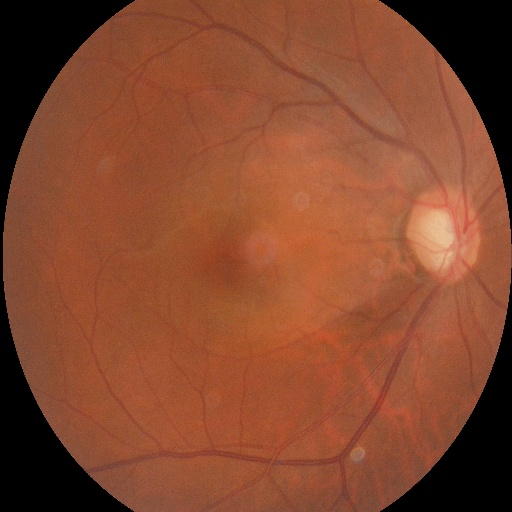

In [ ]:
import random
from PIL import Image
# 设置数据路径
image_path = Path('/content/drive/My Drive/archive/preprocessed_images') #此路径为新数据集的路径

# Set seed
random.seed(42) # <- try changing this and see what happens

# 1. Get all image paths (* means "any combination")
image_path_list = list(image_path.glob("*.jpg"))

# 2. Get random image path
random_image_path = random.choice(image_path_list)

# 3. Get image class from path name (the image class is the name of the directory where the image is stored)
image_class = random_image_path.parent.stem

# 4. Open image
img = Image.open(random_image_path)

# 5. Print metadata
print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}")
print(f"Image width: {img.width}")
img

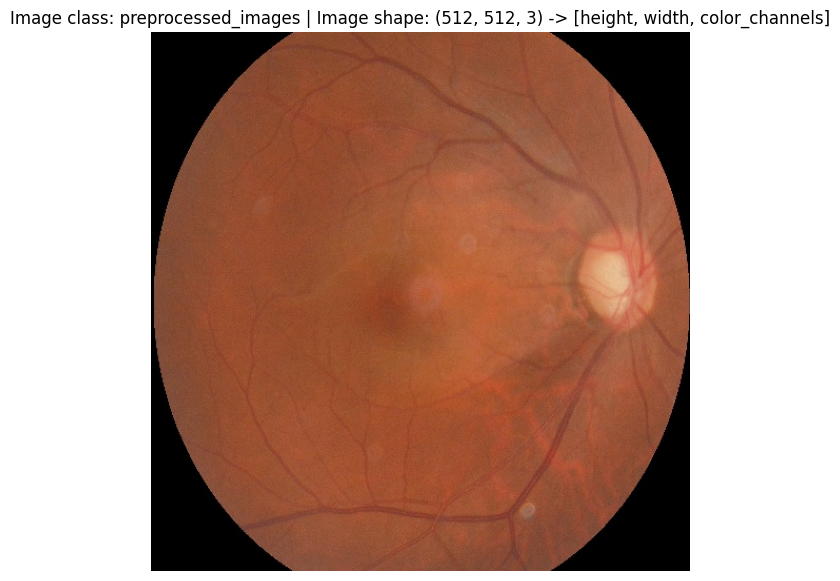

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Turn the image into an array
img_as_array = np.asarray(img)

# Plot the image with matplotlib
plt.figure(figsize=(10, 7))
plt.imshow(img_as_array)
plt.title(f"Image class: {image_class} | Image shape: {img_as_array.shape} -> [height, width, color_channels]")
plt.axis(False);

In [ ]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

In [ ]:
# Write transform for image
data_transform = transforms.Compose([
    # Resize the images to 64x64
    transforms.Resize(size=(64, 64)),
    # Flip the images randomly on the horizontal
    transforms.RandomHorizontalFlip(p=0.5), # p = probability of flip, 0.5 = 50% chance
    # Turn the image into a torch.Tensor
    transforms.ToTensor() # this also converts all pixel values from 0 to 255 to be between 0.0 and 1.0
])

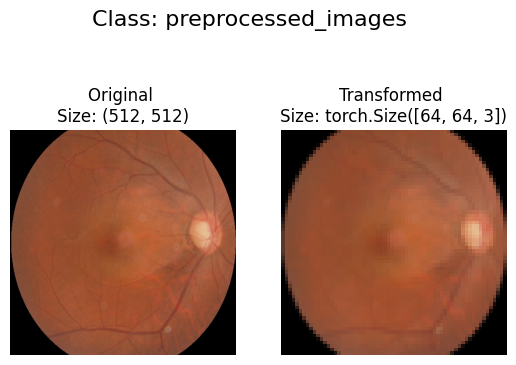

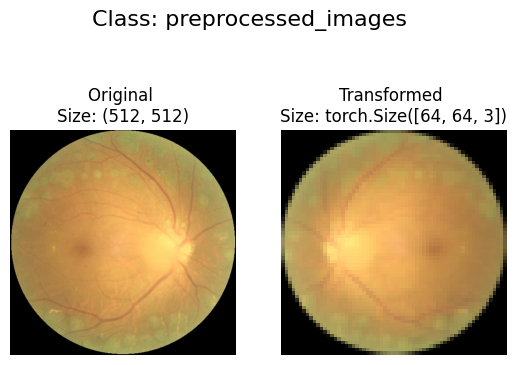

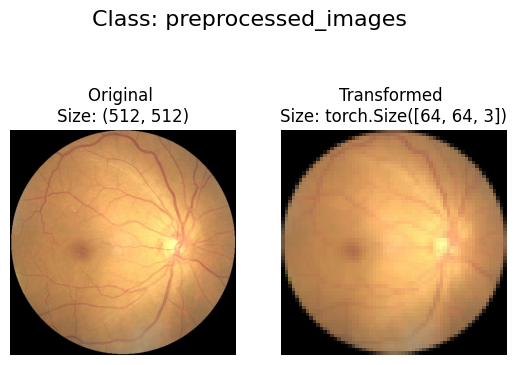

In [ ]:
def plot_transformed_images(image_paths, transform, n=3, seed=42):
    """Plots a series of random images from image_paths.

    Will open n image paths from image_paths, transform them
    with transform and plot them side by side.

    Args:
        image_paths (list): List of target image paths.
        transform (PyTorch Transforms): Transforms to apply to images.
        n (int, optional): Number of images to plot. Defaults to 3.
        seed (int, optional): Random seed for the random generator. Defaults to 42.
    """
    random.seed(seed)
    random_image_paths = random.sample(image_paths, k=n)
    for image_path in random_image_paths:
        with Image.open(image_path) as f:
            fig, ax = plt.subplots(1, 2)
            ax[0].imshow(f)
            ax[0].set_title(f"Original \nSize: {f.size}")
            ax[0].axis("off")

            # Transform and plot image
            # Note: permute() will change shape of image to suit matplotlib
            # (PyTorch default is [C, H, W] but Matplotlib is [H, W, C])
            transformed_image = transform(f).permute(1, 2, 0)
            ax[1].imshow(transformed_image)
            ax[1].set_title(f"Transformed \nSize: {transformed_image.shape}")
            ax[1].axis("off")

            fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)

plot_transformed_images(image_path_list,
                        transform=data_transform,
                        n=3)

In [ ]:
import pandas as pd

# 读取 Excel 文件
xlsx_path = "/content/drive/MyDrive/archive/ODIR-5K/ODIR-5K/data.xlsx"  # 确保路径拼写正确
df = pd.read_excel(xlsx_path)  # 替换为你的 Excel 文件路径


# 查看数据
print(df.head())

   ID  Patient Age Patient Sex Left-Fundus Right-Fundus  \
0   0           69      Female  0_left.jpg  0_right.jpg   
1   1           57        Male  1_left.jpg  1_right.jpg   
2   2           42        Male  2_left.jpg  2_right.jpg   
3   3           66        Male  3_left.jpg  3_right.jpg   
4   4           53        Male  4_left.jpg  4_right.jpg   

                            Left-Diagnostic Keywords  \
0                                           cataract   
1                                      normal fundus   
2  laser spot，moderate non proliferative retinopathy   
3                                      normal fundus   
4                        macular epiretinal membrane   

                Right-Diagnostic Keywords  N  D  G  C  A  H  M  O  
0                           normal fundus  0  0  0  1  0  0  0  0  
1                           normal fundus  1  0  0  0  0  0  0  0  
2  moderate non proliferative retinopathy  0  1  0  0  0  0  0  1  
3         branch retinal artery occl

以下代码只需运行一次（注意：数据集的图片会被移动）

In [ ]:
# import os
# from pathlib import Path
# import pandas as pd
# from sklearn.model_selection import train_test_split
# import shutil

# # 定义类别标签
# classes = ['N', 'D', 'G', 'C', 'A', 'H', 'M', 'O']

# # 定义数据集路径
# preprocessed_dir = '/content/drive/MyDrive/archive/preprocessed_images'
# train_dir = '/content/drive/MyDrive/aritifical intelligent/ODIR/New Training Images'
# test_dir = '/content/drive/MyDrive/aritifical intelligent/ODIR/New Testing Images'
# excel_path = '/content/drive/MyDrive/aritifical intelligent/data.xlsx'

# # 创建新的训练集和测试集的类别文件夹
# def create_category_folders(base_dir):
#     base_dir = Path(base_dir)
#     for cls in classes:
#         (base_dir / cls).mkdir(parents=True, exist_ok=True)

# create_category_folders(train_dir)
# create_category_folders(test_dir)

# # 数据集拆分及分类存放
# def split_and_organize_images(preprocessed_dir, train_dir, test_dir, excel_path, test_size=0.2):
#     """
#     将预处理的图片拆分为训练集和测试集，并按类别存放。

#     Args:
#         preprocessed_dir (str): 所有图片的目录。
#         train_dir (str): 新的训练集的基目录。
#         test_dir (str): 新的测试集的基目录。
#         excel_path (str): 包含类别标签的 Excel 文件路径。
#         test_size (float): 测试集的比例。
#     """
#     # 读取 Excel 文件
#     df = pd.read_excel(excel_path)

#     # 初始化存储图片路径和标签的列表
#     image_paths = []
#     image_labels = []

#     # 遍历 Excel 文件中的每一行
#     for _, row in df.iterrows():
#         left_image = row["Left-Fundus"]
#         right_image = row["Right-Fundus"]
#         left_labels = row[classes].values.tolist()  # 左眼的多分类标签
#         right_labels = row[classes].values.tolist()  # 右眼的多分类标签

#         # 左眼图片路径和标签
#         image_paths.append(os.path.join(preprocessed_dir, left_image))
#         image_labels.append(left_labels)

#         # 右眼图片路径和标签
#         image_paths.append(os.path.join(preprocessed_dir, right_image))
#         image_labels.append(right_labels)

#     # 拆分训练集和测试集
#     train_paths, test_paths, train_labels, test_labels = train_test_split(
#         image_paths, image_labels, test_size=test_size, random_state=42
#     )

#     # 将图片移动到对应的类别文件夹
#     def move_images_to_category(paths, labels, base_dir):
#         for img_path, label in zip(paths, labels):
#             if not os.path.exists(img_path):  # 如果图片不存在，跳过
#                 print(f"Warning: {img_path} does not exist.")
#                 continue

#             # 将图片移动到对应的类别文件夹中
#             for cls, is_present in zip(classes, label):
#                 if is_present == 1:  # 如果该类别标签为 1，则将图片归类到该类别
#                     dest_dir = os.path.join(base_dir, cls)
#                     shutil.copy(img_path, dest_dir)  # 复制图片到目标文件夹
#                     print(f"Moved {img_path} to {dest_dir}")
#                     break  # 一个图片只能归类到一个类别

#     # 处理训练集图片
#     print("Organizing training images...")
#     move_images_to_category(train_paths, train_labels, train_dir)

#     # 处理测试集图片
#     print("Organizing testing images...")
#     move_images_to_category(test_paths, test_labels, test_dir)

# # 调用函数完成数据集的拆分和分类存放
# split_and_organize_images(preprocessed_dir, train_dir, test_dir, excel_path)

In [ ]:
# 以下路径为新路径，运行后会自动在drive中创建这个路径
train_dir = '/content/drive/MyDrive/aritifical intelligent/ODIR/New Training Images'
test_dir = '/content/drive/MyDrive/aritifical intelligent/ODIR/New Testing Images'

In [ ]:
from pathlib import Path

def check_images_in_categories(data_dir):
    """
    检查每个类别文件夹中是否有图片文件
    Args:
        data_dir (str): 数据集根目录路径
    """
    data_dir = Path(data_dir)
    for category in data_dir.iterdir():
        if category.is_dir():  # 只检查文件夹
            images = list(category.glob("*.jpg"))  # 查找 .jpg 文件
            print(f"Category: {category.name}, Images: {len(images)}")
            if len(images) > 0:
                print(f"  Example image: {images[0].name}")

# 检查训练集和测试集
print("Checking training images:")
check_images_in_categories(train_dir)

print("\nChecking testing images:")
check_images_in_categories(test_dir)

Checking training images:
Category: N, Images: 1689
  Example image: 3114_left.jpg
Category: D, Images: 1696
  Example image: 4351_left.jpg
Category: G, Images: 283
  Example image: 1212_right.jpg
Category: C, Images: 255
  Example image: 2221_right.jpg
Category: A, Images: 224
  Example image: 1869_left.jpg
Category: H, Images: 69
  Example image: 62_left.jpg
Category: M, Images: 202
  Example image: 771_right.jpg
Category: O, Images: 694
  Example image: 517_left.jpg

Checking testing images:
Category: N, Images: 412
  Example image: 2798_left.jpg
Category: D, Images: 427
  Example image: 4400_left.jpg
Category: G, Images: 58
  Example image: 1277_left.jpg
Category: C, Images: 67
  Example image: 2167_left.jpg
Category: A, Images: 43
  Example image: 1830_left.jpg
Category: H, Images: 18
  Example image: 777_left.jpg
Category: M, Images: 55
  Example image: 382_right.jpg
Category: O, Images: 200
  Example image: 1028_left.jpg


In [ ]:
import os

def check_image_extensions(directory):
    supported_extensions = {'.jpg', '.jpeg', '.png', '.bmp', '.gif', '.tiff', '.webp'}
    for root, _, files in os.walk(directory):
        for file in files:
            ext = os.path.splitext(file)[-1].lower()  # 获取文件扩展名
            if ext not in supported_extensions:
                print(f"Unsupported file: {os.path.join(root, file)}")

# 检查训练集和测试集文件夹
check_image_extensions('/content/drive/MyDrive/aritifical intelligent/ODIR/New Training Images')
check_image_extensions('/content/drive/MyDrive/aritifical intelligent/ODIR/New Testing Images')

In [ ]:
import os

def check_folder_structure(directory):
    for root, dirs, files in os.walk(directory):
        print(f"Directory: {root}")
        print(f"  Subfolders: {dirs}")
        print(f"  Files: {files[:5]}{'...' if len(files) > 5 else ''}")  # 只展示前5个文件

# 检查训练集和测试集文件夹
print("Training directory structure:")
check_folder_structure('/content/drive/MyDrive/aritifical intelligent/ODIR/New Training Images')

print("\nTesting directory structure:")
check_folder_structure('/content/drive/MyDrive/aritifical intelligent/ODIR/New Testing Images')

Training directory structure:
Directory: /content/drive/MyDrive/aritifical intelligent/ODIR/New Training Images
  Subfolders: ['N', 'D', 'G', 'C', 'A', 'H', 'M', 'O']
  Files: []
Directory: /content/drive/MyDrive/aritifical intelligent/ODIR/New Training Images/N
  Subfolders: []
  Files: ['3114_left.jpg', '3312_right.jpg', '2520_left.jpg', '2725_left.jpg', '3374_left.jpg']...
Directory: /content/drive/MyDrive/aritifical intelligent/ODIR/New Training Images/D
  Subfolders: []
  Files: ['4351_left.jpg', '753_left.jpg', '4181_right.jpg', '3960_right.jpg', '4081_left.jpg']...
Directory: /content/drive/MyDrive/aritifical intelligent/ODIR/New Training Images/G
  Subfolders: []
  Files: ['1212_right.jpg', '1277_right.jpg', '1213_left.jpg', '1431_left.jpg', '1408_left.jpg']...
Directory: /content/drive/MyDrive/aritifical intelligent/ODIR/New Training Images/C
  Subfolders: []
  Files: ['2221_right.jpg', '2112_left.jpg', '2170_left.jpg', '2136_left.jpg', '2113_left.jpg']...
Directory: /content/

In [ ]:
print(f"Training directory: {train_dir}")
print(f"Testing directory: {test_dir}")

Training directory: /content/drive/MyDrive/aritifical intelligent/ODIR/New Training Images
Testing directory: /content/drive/MyDrive/aritifical intelligent/ODIR/New Testing Images


In [ ]:
from torchvision import datasets
from torchvision import transforms

# 数据预处理
data_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

# 检查路径
train_dir = '/content/drive/MyDrive/aritifical intelligent/ODIR/New Training Images'
test_dir = '/content/drive/MyDrive/aritifical intelligent/ODIR/New Testing Images'

# 加载训练集和测试集
train_data = datasets.ImageFolder(root=train_dir, transform=data_transform)
test_data = datasets.ImageFolder(root=test_dir, transform=data_transform)

print(f"Train data size: {len(train_data)} images")
print(f"Test data size: {len(test_data)} images")
print(f"Classes: {train_data.classes}")
print(f"Classes: {test_data.classes}")

Train data size: 5112 images
Test data size: 1280 images
Classes: ['A', 'C', 'D', 'G', 'H', 'M', 'N', 'O']
Classes: ['A', 'C', 'D', 'G', 'H', 'M', 'N', 'O']


In [ ]:
from torchvision import datasets
from torchvision import transforms

# 数据预处理
data_transform = transforms.Compose([
    transforms.Resize((64, 64)),  # 调整图像大小为 64x64
    transforms.ToTensor()         # 转换为张量
])

# 加载训练集和测试集
train_data = datasets.ImageFolder(root=train_dir, transform=data_transform)
test_data = datasets.ImageFolder(root=test_dir, transform=data_transform)

print(f"Train data:\n{train_data}\nTest data:\n{test_data}")

# 检查类别
print(f"Classes: {train_data.classes}")  # 打印类别列表

Train data:
Dataset ImageFolder
    Number of datapoints: 5112
    Root location: /content/drive/MyDrive/aritifical intelligent/ODIR/New Training Images
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
           )
Test data:
Dataset ImageFolder
    Number of datapoints: 1280
    Root location: /content/drive/MyDrive/aritifical intelligent/ODIR/New Testing Images
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
           )
Classes: ['A', 'C', 'D', 'G', 'H', 'M', 'N', 'O']


In [ ]:
# Get class names as a list
class_names = train_data.classes
class_names

['A', 'C', 'D', 'G', 'H', 'M', 'N', 'O']

In [ ]:
# Check the lengths
len(train_data), len(test_data)

(5112, 1280)

In [ ]:
img, label = train_data[0][0], train_data[0][1]
print(f"Image tensor:\n{img}")
print(f"Image shape: {img.shape}")
print(f"Image datatype: {img.dtype}")
print(f"Image label: {label}")
print(f"Label datatype: {type(label)}")

Image tensor:
tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]])
Image shape: torch.Size([3, 64, 64])
Image datatype: torch.float32
Image label: 0
Label datatype: <class 'int'>


Original shape: torch.Size([3, 64, 64]) -> [color_channels, height, width]
Image permute shape: torch.Size([64, 64, 3]) -> [height, width, color_channels]


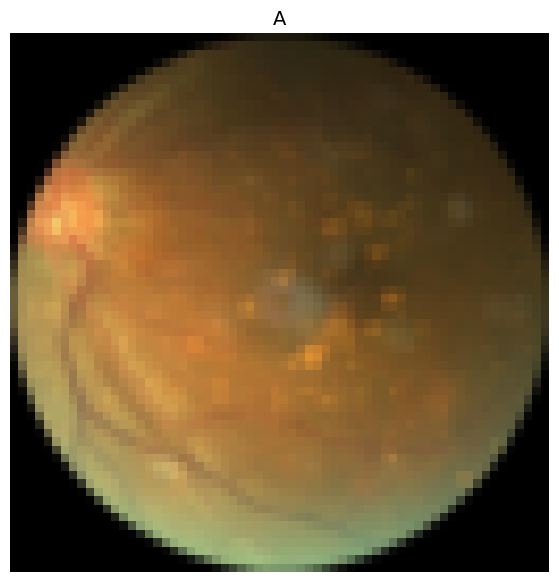

In [ ]:
# Rearrange the order of dimensions
img_permute = img.permute(1, 2, 0)

# Print out different shapes (before and after permute)
print(f"Original shape: {img.shape} -> [color_channels, height, width]")
print(f"Image permute shape: {img_permute.shape} -> [height, width, color_channels]")

# Plot the image
plt.figure(figsize=(10, 7))
plt.imshow(img.permute(1, 2, 0))
plt.axis("off")
plt.title(class_names[label], fontsize=14);

In [ ]:
# Turn train and test Datasets into DataLoaders
from torch.utils.data import DataLoader
train_dataloader = DataLoader(dataset=train_data,
                              batch_size=1, # how many samples per batch?
                              num_workers=1, # how many subprocesses to use for data loading? (higher = more)
                              shuffle=True) # shuffle the data?

test_dataloader = DataLoader(dataset=test_data,
                             batch_size=1,
                             num_workers=1,
                             shuffle=False) # don't usually need to shuffle testing data

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7fe65774ed90>,
 <torch.utils.data.dataloader.DataLoader at 0x7fe6583014d0>)

In [ ]:
img, label = next(iter(train_dataloader))

# Batch size will now be 1, try changing the batch_size parameter above and see what happens
print(f"Image shape: {img.shape} -> [batch_size, color_channels, height, width]")
print(f"Label shape: {label.shape}")

Image shape: torch.Size([1, 3, 64, 64]) -> [batch_size, color_channels, height, width]
Label shape: torch.Size([1])


In [ ]:
from typing import List

In [ ]:
# 1. Take in a Dataset as well as a list of class names
def display_random_images(dataset: torch.utils.data.dataset.Dataset,
                          classes: List[str] = None,
                          n: int = 10,
                          display_shape: bool = True,
                          seed: int = None):

    # 2. Adjust display if n too high
    if n > 10:
        n = 10
        display_shape = False
        print(f"For display purposes, n shouldn't be larger than 10, setting to 10 and removing shape display.")

    # 3. Set random seed
    if seed:
        random.seed(seed)

    # 4. Get random sample indexes
    random_samples_idx = random.sample(range(len(dataset)), k=n)

    # 5. Setup plot
    plt.figure(figsize=(16, 8))

    # 6. Loop through samples and display random samples
    for i, targ_sample in enumerate(random_samples_idx):
        targ_image, targ_label = dataset[targ_sample][0], dataset[targ_sample][1]

        # 7. Adjust image tensor shape for plotting: [color_channels, height, width] -> [color_channels, height, width]
        targ_image_adjust = targ_image.permute(1, 2, 0)

        # Plot adjusted samples
        plt.subplot(1, n, i+1)
        plt.imshow(targ_image_adjust)
        plt.axis("off")
        if classes:
            title = f"class: {classes[targ_label]}"
            if display_shape:
                title = title + f"\nshape: {targ_image_adjust.shape}"
        plt.title(title)

For display purposes, n shouldn't be larger than 10, setting to 10 and removing shape display.


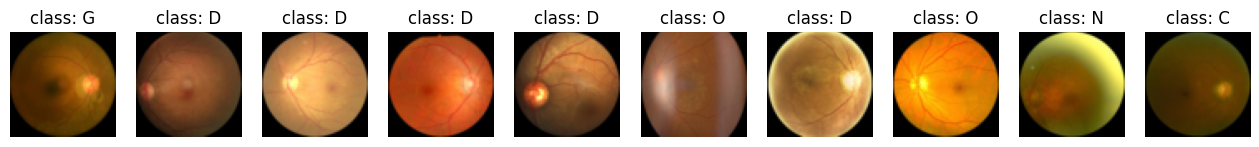

In [ ]:
# Display random images from ImageFolder created Dataset
display_random_images(train_data,
                      n=12,
                      classes=class_names,
                      seed=None)

In [ ]:
# Turn train and test custom Dataset's into DataLoader's
from torch.utils.data import DataLoader
train_dataloader_custom = DataLoader(dataset=train_data, # use custom created train Dataset
                                     batch_size=1, # how many samples per batch?
                                     num_workers=0, # how many subprocesses to use for data loading? (higher = more)
                                     shuffle=True) # shuffle the data?

test_dataloader_custom = DataLoader(dataset=test_data, # use custom created test Dataset
                                    batch_size=1,
                                    num_workers=0,
                                    shuffle=False) # don't usually need to shuffle testing data

train_dataloader_custom, test_dataloader_custom

(<torch.utils.data.dataloader.DataLoader at 0x7fe6578e7c10>,
 <torch.utils.data.dataloader.DataLoader at 0x7fe65778b7d0>)

In [ ]:
# Get image and label from custom DataLoader
img_custom, label_custom = next(iter(train_dataloader_custom))

# Batch size will now be 1, try changing the batch_size parameter above and see what happens
print(f"Image shape: {img_custom.shape} -> [batch_size, color_channels, height, width]")
print(f"Label shape: {label_custom.shape}")

Image shape: torch.Size([1, 3, 64, 64]) -> [batch_size, color_channels, height, width]
Label shape: torch.Size([1])


In [ ]:
import torch
import torch.nn as nn
import torch

# 检查是否有可用的 GPU，如果有则使用 GPU，否则使用 CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"Using device: {device}")

Using device: cuda


In [ ]:
# Create training transform with TrivialAugment
train_transform_trivial_augment = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor()
])

# Create testing transform (no data augmentation)
test_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

In [ ]:
# Turn image folders into Datasets
train_data_augmented = datasets.ImageFolder(train_dir, transform=train_transform_trivial_augment)
test_data_simple = datasets.ImageFolder(test_dir, transform=test_transform)

train_data_augmented, test_data_simple

(Dataset ImageFolder
     Number of datapoints: 5112
     Root location: /content/drive/MyDrive/aritifical intelligent/ODIR/New Training Images
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                TrivialAugmentWide(num_magnitude_bins=31, interpolation=InterpolationMode.NEAREST, fill=None)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 1280
     Root location: /content/drive/MyDrive/aritifical intelligent/ODIR/New Testing Images
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                ToTensor()
            ))

In [ ]:
print(f"Train data root: {train_data_augmented.root}")
print(f"Test data root: {test_data_simple.root}")

Train data root: /content/drive/MyDrive/aritifical intelligent/ODIR/New Training Images
Test data root: /content/drive/MyDrive/aritifical intelligent/ODIR/New Testing Images


In [ ]:
print(f"Number of training samples: {len(train_data_augmented)}")
print(f"Number of testing samples: {len(test_data_simple)}")

Number of training samples: 5112
Number of testing samples: 1280


In [ ]:
# Turn Datasets into DataLoader's
import os
BATCH_SIZE = 64
NUM_WORKERS = os.cpu_count()

torch.manual_seed(42)
train_dataloader_augmented = DataLoader(train_data_augmented,
                                        batch_size=BATCH_SIZE,
                                        shuffle=True,
                                        num_workers=NUM_WORKERS)

test_dataloader_simple = DataLoader(test_data_simple,
                                    batch_size=BATCH_SIZE,
                                    shuffle=False,
                                    num_workers=NUM_WORKERS)

train_dataloader_augmented, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7fe657814e50>,
 <torch.utils.data.dataloader.DataLoader at 0x7fe6583014d0>)

# Build Efficient model

In [ ]:
# pip install timm

In [ ]:
import torch
import torch.nn as nn
from timm import create_model

In [ ]:
class EfficientNetModified(nn.Module):
    """
    EfficientNet-based model.
    Replacing TinyVGG with EfficientNet while retaining the structure of the original code.
    """
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int) -> None:
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape,
                      out_channels=hidden_units,
                      kernel_size=3, # how big is the square that's going over the image?
                      stride=1, # default
                      padding=1), # options = "valid" (no padding) or "same" (output has same shape as input) or int for specific number
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2) # default stride value is same as kernel_size
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            # Where did this in_features shape come from?
            # It's because each layer of our network compresses and changes the shape of our input data.
            nn.Linear(in_features=hidden_units*16*16,
                      out_features=output_shape)
        )

    def forward(self, x: torch.Tensor):
        x = self.conv_block_1(x)
        # print(x.shape)
        x = self.conv_block_2(x)
        # print(x.shape)
        x = self.classifier(x)
        # print(x.shape)
        return x
        # return self.classifier(self.conv_block_2(self.conv_block_1(x))) # <- leverage the benefits of operator fusion

In [ ]:
# Create model_2 and send it to the target device
torch.manual_seed(42)
model_2 = EfficientNetModified(
    input_shape=3,
    hidden_units=10,
    output_shape=len(train_data_augmented.classes)).to(device)
model_2

EfficientNetModified(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=2560, out_features=8, bias=True)
  )
)

In [ ]:
from tqdm.auto import tqdm

# 1. Take in various parameters required for training and test steps
def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5):

    # 2. Create empty results dictionary
    results = {"train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": []
    }

    # 3. Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                           dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer)
        test_loss, test_acc = test_step(model=model,
            dataloader=test_dataloader,
            loss_fn=loss_fn)

        # 4. Print out what's happening
        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"test_loss: {test_loss:.4f} | "
            f"test_acc: {test_acc:.4f}"
        )

        # 5. Update results dictionary
        # Ensure all data is moved to CPU and converted to float for storage
        results["train_loss"].append(train_loss.item() if isinstance(train_loss, torch.Tensor) else train_loss)
        results["train_acc"].append(train_acc.item() if isinstance(train_acc, torch.Tensor) else train_acc)
        results["test_loss"].append(test_loss.item() if isinstance(test_loss, torch.Tensor) else test_loss)
        results["test_acc"].append(test_acc.item() if isinstance(test_acc, torch.Tensor) else test_acc)

    # 6. Return the filled results at the end of the epochs
    return results

In [ ]:
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer):
    # Put model in train mode
    model.train()

    # Setup train loss and train accuracy values
    train_loss, train_acc = 0, 0

    # Loop through data loader data batches
    for batch, (X, y) in enumerate(dataloader):
        # Send data to target device
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate  and accumulate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        # Calculate and accumulate accuracy metrics across all batches
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)

    # Adjust metrics to get average loss and accuracy per batch
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

In [ ]:
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module):
    # Put model in eval mode
    model.eval()

    # Setup test loss and test accuracy values
    test_loss, test_acc = 0, 0

    # Turn on inference context manager
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (X, y) in enumerate(dataloader):
            # Send data to target device
            X, y = X.to(device), y.to(device)

            # 1. Forward pass
            test_pred_logits = model(X)

            # 2. Calculate and accumulate loss
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()

            # Calculate and accumulate accuracy
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

    # Adjust metrics to get average loss and accuracy per batch
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

about 12 mins, accuracy about 50%

In [ ]:
# Set random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set number of epochs
NUM_EPOCHS = 50

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_2.parameters(), lr=0.001)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Train model_2
model_2_results = train(model=model_2,
                        train_dataloader=train_dataloader_augmented,
                        test_dataloader=test_dataloader_simple,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=NUM_EPOCHS)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.6735 | train_acc: 0.3195 | test_loss: 1.6326 | test_acc: 0.3336
Epoch: 2 | train_loss: 1.6419 | train_acc: 0.3249 | test_loss: 1.6302 | test_acc: 0.3812
Epoch: 3 | train_loss: 1.6342 | train_acc: 0.3573 | test_loss: 1.6083 | test_acc: 0.3758
Epoch: 4 | train_loss: 1.6296 | train_acc: 0.3593 | test_loss: 1.6119 | test_acc: 0.3555
Epoch: 5 | train_loss: 1.6232 | train_acc: 0.3635 | test_loss: 1.5889 | test_acc: 0.3937
Epoch: 6 | train_loss: 1.6248 | train_acc: 0.3561 | test_loss: 1.5850 | test_acc: 0.3742
Epoch: 7 | train_loss: 1.6142 | train_acc: 0.3732 | test_loss: 1.5775 | test_acc: 0.3648
Epoch: 8 | train_loss: 1.6130 | train_acc: 0.3628 | test_loss: 1.5697 | test_acc: 0.3906
Epoch: 9 | train_loss: 1.6180 | train_acc: 0.3639 | test_loss: 1.5745 | test_acc: 0.3477
Epoch: 10 | train_loss: 1.6028 | train_acc: 0.3684 | test_loss: 1.5559 | test_acc: 0.3773
Epoch: 11 | train_loss: 1.6047 | train_acc: 0.3675 | test_loss: 1.5648 | test_acc: 0.3711
Epoch: 12 | train_l

# Evaluate Efficient model

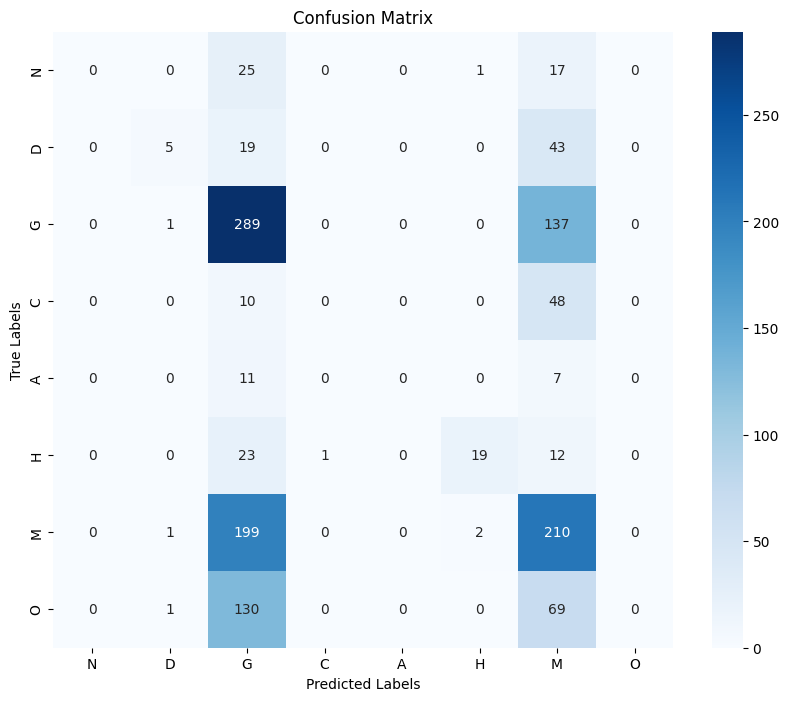

Classification Report:
              precision    recall  f1-score   support

           N       0.00      0.00      0.00        43
           D       0.62      0.07      0.13        67
           G       0.41      0.68      0.51       427
           C       0.00      0.00      0.00        58
           A       0.00      0.00      0.00        18
           H       0.86      0.35      0.49        55
           M       0.39      0.51      0.44       412
           O       0.00      0.00      0.00       200

    accuracy                           0.41      1280
   macro avg       0.29      0.20      0.20      1280
weighted avg       0.33      0.41      0.34      1280


Detailed Metrics:
N: Precision=0.0000, Recall=0.0000, F1-Score=0.0000, Support=43
D: Precision=0.6250, Recall=0.0746, F1-Score=0.1333, Support=67
G: Precision=0.4093, Recall=0.6768, F1-Score=0.5102, Support=427
C: Precision=0.0000, Recall=0.0000, F1-Score=0.0000, Support=58
A: Precision=0.0000, Recall=0.0000, F1-Score=0.000

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

In [ ]:
import torch
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    precision_recall_fscore_support,
    accuracy_score,
)
import seaborn as sns
import matplotlib.pyplot as plt

# 绘制混淆矩阵并输出性能指标
def evaluate_and_report_metrics(model, dataloader, class_names, device="cuda"):
    """
    评估模型，绘制混淆矩阵并输出 Accuracy、Precision、Recall、F1-Score 等指标。

    Args:
        model (torch.nn.Module): 训练好的模型。
        dataloader (DataLoader): 测试集数据加载器。
        class_names (list): 类别名称列表。
        device (str): 设备类型 ("cuda" 或 "cpu")。
    """
    model.eval()  # 设置模型为评估模式
    y_true = []  # 存储真实标签
    y_pred = []  # 存储预测标签

    # 禁用梯度计算以加速推理
    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)  # 将数据移至 GPU 或 CPU
            labels = labels.to(device)

            # 前向传播
            outputs = model(images)
            _, predictions = torch.max(outputs, 1)  # 获取预测类别

            y_true.extend(labels.cpu().numpy())  # 收集真实标签
            y_pred.extend(predictions.cpu().numpy())  # 收集预测标签

    # 混淆矩阵
    cm = confusion_matrix(y_true, y_pred)

    # 可视化混淆矩阵
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title("Confusion Matrix")
    plt.show()

    # 输出分类报告 (Precision, Recall, F1-Score)
    print("Classification Report:")
    print(classification_report(y_true, y_pred, target_names=class_names))

    # 计算每类的 Precision, Recall, F1-Score
    precision, recall, f1, support = precision_recall_fscore_support(y_true, y_pred, average=None)

    # 按类别输出 Precision, Recall, F1
    print("\nDetailed Metrics:")
    for i, class_name in enumerate(class_names):
        print(f"{class_name}: Precision={precision[i]:.4f}, Recall={recall[i]:.4f}, F1-Score={f1[i]:.4f}, Support={support[i]}")

    # 计算和输出总体准确率
    accuracy = accuracy_score(y_true, y_pred)
    print(f"\nOverall Accuracy: {accuracy:.4f}")

    # 输出宏平均和加权平均的指标
    precision_macro, recall_macro, f1_macro, _ = precision_recall_fscore_support(y_true, y_pred, average="macro")
    precision_weighted, recall_weighted, f1_weighted, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")

    print("\nSummary:")
    print(f"Macro Average: Precision={precision_macro:.4f}, Recall={recall_macro:.4f}, F1-Score={f1_macro:.4f}")
    print(f"Weighted Average: Precision={precision_weighted:.4f}, Recall={recall_weighted:.4f}, F1-Score={f1_weighted:.4f}")

# 假设你的类别名称如下
class_names = ['N', 'D', 'G', 'C', 'A', 'H', 'M', 'O']

# 调用函数进行评估
evaluate_and_report_metrics(model_2, test_dataloader_simple, class_names)

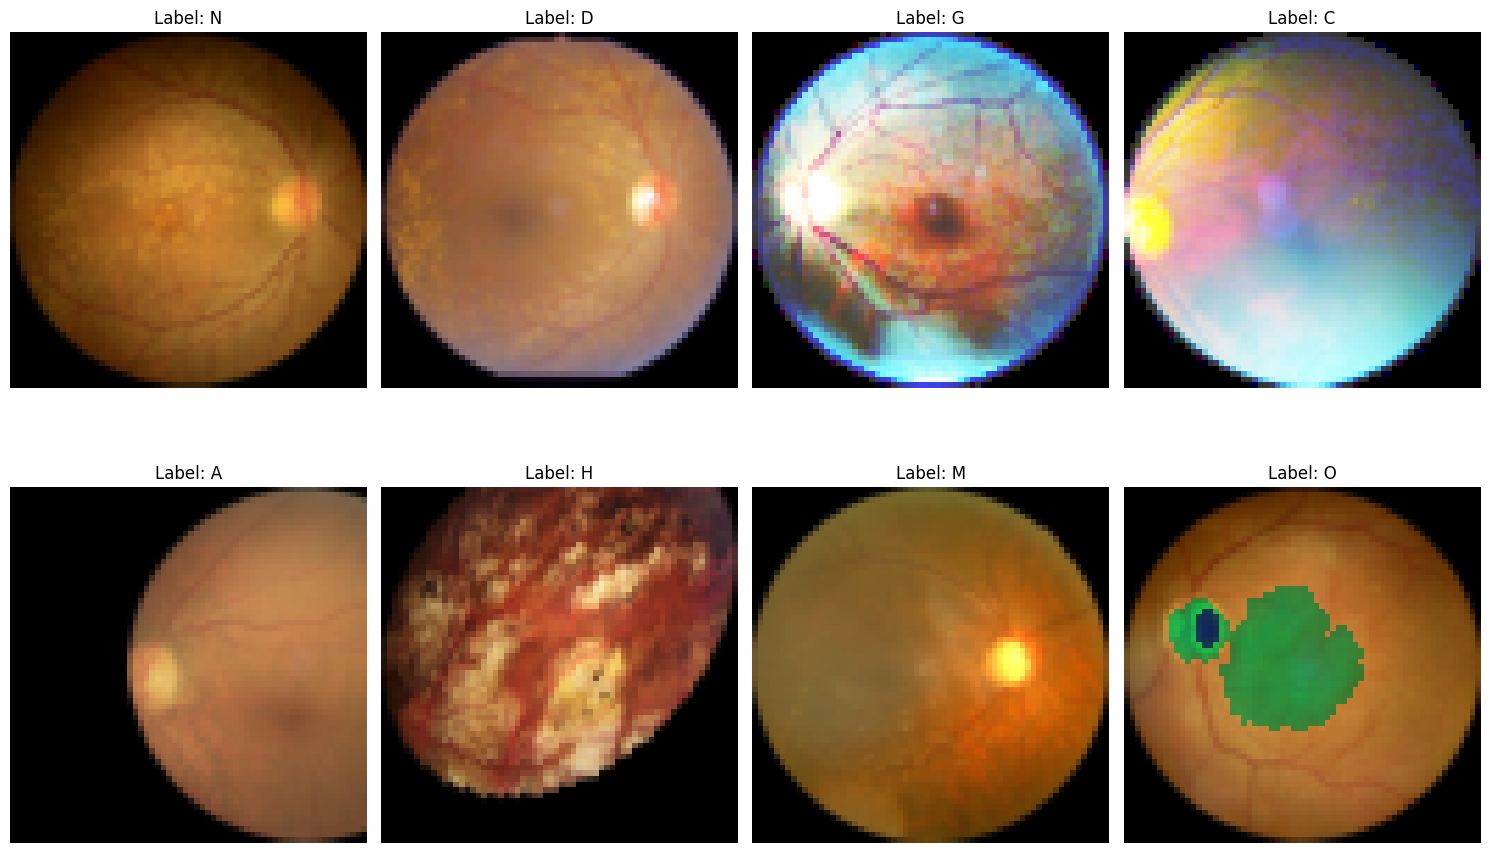

In [ ]:
import matplotlib.pyplot as plt

# 显示每个类别的图像
def plot_images_by_classes(dataloader, class_names, num_classes=8):
    """
    从数据加载器中展示每个类别的一张图像。

    Args:
        dataloader (DataLoader): 数据加载器。
        class_names (list): 类别名称列表。
        num_classes (int): 类别数量。
    """
    images_shown = [False] * num_classes  # 每个类别是否已经展示的标记
    plt.figure(figsize=(15, 10))  # 设置画布大小

    # 遍历数据加载器
    for images, labels in dataloader:
        for img, label in zip(images, labels):
            label = label.item()  # 获取类别索引
            if not images_shown[label]:  # 如果该类别还未展示
                images_shown[label] = True
                plt.subplot(2, 4, label + 1)  # 创建子图 (2 行 4 列)
                plt.imshow(img.permute(1, 2, 0))  # 调整维度用于显示
                plt.title(f"Label: {class_names[label]}")
                plt.axis("off")  # 隐藏坐标轴

            # 如果所有类别都展示完毕，直接退出
            if all(images_shown):
                break
        if all(images_shown):
            break

    plt.tight_layout()
    plt.show()

# 假设你的类别名称如下
class_names = ['N', 'D', 'G', 'C', 'A', 'H', 'M', 'O']

# 调用函数展示图像
plot_images_by_classes(train_dataloader_augmented, class_names)

# Build VGG model

In [ ]:
import numpy as np
import pandas as pd
import cv2
import random
from tqdm import tqdm
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/archive(V2)/full_df.csv") #更換爲自己的路徑
df.head(3)

,ID,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,N,D,G,C,A,H,M,O,filepath,labels,target,filename
0,0,69,Female,0_left.jpg,0_right.jpg,cataract,normal fundus,0,0,0,1,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",0_right.jpg
1,1,57,Male,1_left.jpg,1_right.jpg,normal fundus,normal fundus,1,0,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",1_right.jpg
2,2,42,Male,2_left.jpg,2_right.jpg,laser spot，moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",2_right.jpg


about 50mins

In [ ]:
import os
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.applications.vgg16 import VGG16 as vgg
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import confusion_matrix, classification_report

# 定义数据集目录
dataset_dir = "/content/drive/MyDrive/archive(V2)/preprocessed_images"  # 更換爲自己的路徑

# 定义所有类别标签
classes = ['N', 'D', 'G', 'C', 'A', 'H', 'M', 'O']
class_to_label = {cls: idx for idx, cls in enumerate(classes)}

# 修改标签生成函数
def get_labels(text):
    labels = []
    for cls in classes:
        if cls in text:
            labels.append(1)
        else:
            labels.append(0)
    return labels

# 生成多分类标签
df["left_labels"] = df["Left-Diagnostic Keywords"].apply(get_labels)
df["right_labels"] = df["Right-Diagnostic Keywords"].apply(get_labels)

# 修改数据集创建函数
def create_dataset(image_category, labels):
    dataset = []
    for img, label in tqdm(zip(image_category, labels)):
        image_path = os.path.join(dataset_dir, img)
        try:
            image = cv2.imread(image_path, cv2.IMREAD_COLOR)
            image = cv2.resize(image, (224, 224))
            dataset.append([np.array(image), np.array(label)])
        except:
            continue
    random.shuffle(dataset)
    return dataset

# 加载所有类别数据
all_data = []
for cls in classes:
    image_paths = df[df[cls]==1][f'Left-Fundus'].values
    labels = [class_to_label[cls]] * len(image_paths)
    print(f"Class {cls}: Left images found: {len(image_paths)}")
    class_data = create_dataset(image_paths, labels)
    all_data.extend(class_data)
    print(f"Class {cls}: Left images loaded: {len(class_data)}")

    image_paths = df[df[cls]==1][f'Right-Fundus'].values
    labels = [class_to_label[cls]] * len(image_paths)
    print(f"Class {cls}: Right images found: {len(image_paths)}")
    class_data = create_dataset(image_paths, labels)
    all_data.extend(class_data)
    print(f"Class {cls}: Right images loaded: {len(class_data)}")

print(f"Total data loaded: {len(all_data)}")

Class N: Left images found: 2101


2101it [11:48,  2.97it/s]


Class N: Left images loaded: 2071
Class N: Right images found: 2101


570it [06:25,  1.32it/s]

*italicized text*> 30% acc

In [ ]:
# 构建多分类模型
model = Sequential()
model.add(vgg(include_top=False, input_shape=(224, 224, 3)))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(len(classes), activation='softmax'))

# 编译模型
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


In [ ]:
x = np.array([i[0] for i in all_data])
y = np.array([i[1] for i in all_data])

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, stratify=y, random_state=42)


## 1st round

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import VGG16

# 加载 VGG16 并解冻部分层
vgg = VGG16(include_top=False, input_shape=(224, 224, 3))
for layer in vgg.layers[:-4]:
    layer.trainable = False
for layer in vgg.layers[-4:]:
    layer.trainable = True

# 构建模型
model = Sequential()
model.add(vgg)
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(len(classes), activation='softmax'))

# 编译模型
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# 回调函数
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# 计算类权重（如果需要）
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights_dict = dict(enumerate(class_weights))

In [ ]:
# 定义回调函数
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_accuracy', save_best_only=True)
earlystop = EarlyStopping(monitor='val_loss', patience=5)

    # 训练模型
history = model.fit(x_train, y_train,
                        batch_size=32,
                        epochs=20,
                        validation_data=(x_test, y_test),
                        callbacks=[checkpoint, earlystop])

In [ ]:
# 评估
loss, accuracy = model.evaluate(x_test, y_test)
print(f'Test accuracy: {accuracy:.4f}')

# 预测
y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# 混淆矩阵
cm = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(12,10))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion matrix')
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

In [ ]:
# 分类报告
print(classification_report(y_test, y_pred_classes, target_names=classes))

# 预测可视化
plt.figure(figsize=(15,12))
for i in range(20):
    idx = random.randint(0, len(x_test)-1)
    image = x_test[idx]
    true_label = classes[y_test[idx]]
    pred_label = classes[y_pred_classes[idx]]

## 2nd round

In [ ]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# 假设你的数据是 all_data，格式为 [(image, label), ...]
x = np.array([i[0] for i in all_data])  # 图像数据
y = np.array([i[1] for i in all_data])  # 标签

# 划分训练集和测试集
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, stratify=y, random_state=42)

# 数据归一化
x_train = x_train / 255.0
x_test = x_test / 255.0

# 数据增强
datagen = ImageDataGenerator(
    rotation_range=20,         # 随机旋转角度
    width_shift_range=0.2,     # 水平平移
    height_shift_range=0.2,    # 垂直平移
    horizontal_flip=True,      # 随机水平翻转
    fill_mode='nearest'        # 填充模式
)
train_generator = datagen.flow(x_train, y_train, batch_size=32)

In [ ]:
# from tensorflow.keras.applications import VGG16
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense, Flatten, Dropout

# # 加载 VGG16 模型
# vgg = VGG16(include_top=False, input_shape=(224, 224, 3))

# # 解冻最后 4 层进行微调
# for layer in vgg.layers[:-4]:
#     layer.trainable = False  # 冻结前几层
# for layer in vgg.layers[-4:]:
#     layer.trainable = True   # 解冻最后 4 层

# # 构建模型
# model = Sequential()
# model.add(vgg)
# model.add(Flatten())
# model.add(Dense(512, activation='relu'))  # 增加一层全连接层
# model.add(Dropout(0.4))                   # Dropout 比例调整为 0.4
# model.add(Dense(256, activation='relu'))
# model.add(Dropout(0.4))
# model.add(Dense(len(classes), activation='softmax'))  # 输出层，classes 是你的类别数

# # 打印模型结构
# model.summary()

using this plus dense to last 1

In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization

# 加载 VGG16 模型
vgg = VGG16(include_top=False, input_shape=(224, 224, 3))

# 解冻最后 4 层进行微调
for layer in vgg.layers[:-4]:
    layer.trainable = False  # 冻结前几层
for layer in vgg.layers[-4:]:
    layer.trainable = True   # 解冻最后 4 层

# 构建模型
model = Sequential()
model.add(vgg)
model.add(Flatten())
model.add(Dense(1024, activation='relu'))  # 增加神经元数量
model.add(BatchNormalization())  # 添加批归一化层
model.add(Dropout(0.5))  # 调整 Dropout 比例
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(len(classes), activation='softmax'))  # 输出层

# 打印模型结构
model.summary()

In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau

# 编译模型
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# 添加学习率调度器
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

# 添加早停机制
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# 训练模型
history = model.fit(
    train_generator,              # 使用数据增强的训练数据
    epochs=100,                    # 设置较多轮次，早停会自动控制(目前eopchs到36,accuracy能达到70%)
    validation_data=(x_test, y_test),  # 使用测试集作为验证集
    callbacks=[reduce_lr, early_stopping]
)

In [ ]:
# 评估
loss, accuracy = model.evaluate(x_test, y_test)
print(f'Test accuracy: {accuracy:.4f}')

# 预测
y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# 混淆矩阵
cm = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(12,10))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion matrix')
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)



In [ ]:
# 分类报告
print(classification_report(y_test, y_pred_classes, target_names=classes))

# 预测可视化
plt.figure(figsize=(15,12))
for i in range(20):
    idx = random.randint(0, len(x_test)-1)
    image = x_test[idx]
    true_label = classes[y_test[idx]]
    pred_label = classes[y_pred_classes[idx]]

In [ ]:

plt.subplot(4,5,i+1)
plt.imshow(image)
plt.title(f'True: {true_label}\nPred: {pred_label}',
                  color='green' if true_label==pred_label else 'red')
plt.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
dataset = create_dataset(normal,0)

In [ ]:
len(dataset)

**WARNING:** The part below is not neccessary:

><h3>Let's see some images</h3>

Seperate line if multi classification

In [ ]:
plt.figure(figsize=(12,7))
for i in range(10):
    sample = random.choice(range(len(dataset)))
    image = dataset[sample][0]
    category = dataset[sample][1]
    if category== 0:
        label = "Normal"
    else:
        label = "Cataract"
    plt.subplot(2,5,i+1)
    plt.imshow(image)
    plt.xlabel(label)
plt.tight_layout()

><h3>Dividing dataset into x(features) & y(target)</h3>

In [ ]:
x = np.array([i[0] for i in dataset]).reshape(-1,image_size,image_size,3)
y = np.array([i[1] for i in dataset])

In [ ]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2)

><h3>Creating Model</h3>

In [ ]:
# from tensorflow.keras.applications.vgg19 import VGG19
# vgg = VGG19(weights="imagenet",include_top = False,input_shape=(image_size,image_size,3))

In [ ]:
# for layer in vgg.layers:
#     layer.trainable = False

In [ ]:
# from tensorflow.keras import Sequential
# from tensorflow.keras.layers import Flatten,Dense
# model = Sequential()
# model.add(vgg)
# model.add(Flatten())
# model.add(Dense(1,activation="sigmoid"))

In [ ]:
# model.summary()

In [ ]:
# model.compile(optimizer="adam",loss="binary_crossentropy",metrics=["accuracy"])

In [ ]:
# from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
# checkpoint = ModelCheckpoint("vgg19.h5",monitor="val_acc",verbose=1,save_best_only=True,
#                              save_weights_only=False) #,period=1
# # earlystop = EarlyStopping(monitor="val_acc",patience=5,verbose=1) #occur error if use this line

In [ ]:
# earlystop = EarlyStopping(monitor="val_acc", patience=5, verbose=1, mode='max')

In [ ]:
# history = model.fit(x_train,y_train,batch_size=32,epochs=15,validation_data=(x_test,y_test),
#                     verbose=1,callbacks=[checkpoint,earlystop])

In [ ]:
# loss,accuracy = model.evaluate(x_test,y_test)
# print("loss:",loss)
# print("Accuracy:",accuracy)

In [ ]:
# original code
# from sklearn.metrics import confusion_matrix,classification_report,accuracy_score
# y_pred = model.predict_classes(x_test)

In [ ]:
# from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

# # 使用 model.predict 方法进行预测
# y_pred = model.predict(x_test)

# # 将预测结果转换为类别
# y_pred_classes = np.argmax(y_pred, axis=1)

In [ ]:
# y_pred_classes

In [ ]:
# y_test

In [ ]:
# # 将概率转换为 0 或 1，使用阈值 0.5
# y_pred = (y_pred >= 0.5).astype(int)

In [ ]:
# y_pred

In [ ]:
# accuracy_score(y_test,y_pred) #from y_pred to y_pred_classes

In [ ]:
# print(classification_report(y_test,y_pred))

In [ ]:
# from mlxtend.plotting import plot_confusion_matrix
# cm = confusion_matrix(y_test,y_pred)
# plot_confusion_matrix(conf_mat = cm,figsize=(8,7),class_names = ["Normal","Cataract"],
#                       show_normed = True);

><h3>Learning Curve</h3>

In [ ]:
# plt.style.use("ggplot")
# fig = plt.figure(figsize=(12,6))
# epochs = range(1,16)
# plt.subplot(1,2,1)
# plt.plot(epochs,history.history["accuracy"],"go-")
# plt.plot(epochs,history.history["val_accuracy"],"ro-")
# plt.title("Model Accuracy")
# plt.xlabel("Epochs")
# plt.ylabel("Accuracy")
# plt.legend(["Train","val"],loc = "upper left")

# plt.subplot(1,2,2)
# plt.plot(epochs,history.history["loss"],"go-")
# plt.plot(epochs,history.history["val_loss"],"ro-")
# plt.title("Model Loss")
# plt.xlabel("Epochs")
# plt.ylabel("Loss")
# plt.legend(["Train","val"],loc = "upper left")
# plt.show()

><h3>Prediction:</h3>

In [ ]:
# plt.figure(figsize=(12,7))
# for i in range(20):
#     sample = random.choice(range(len(x_test)))
#     image = x_test[sample]
#     category = y_test[sample]
#     pred_category = y_pred[sample]

#     if category== 0:
#         label = "Normal"
#     else:
#         label = "Cataract"

#     if pred_category== 0:
#         pred_label = "Normal"
#     else:
#         pred_label = "Cataract"

#     plt.subplot(4,5,i+1)
#     plt.imshow(image)
#     plt.xlabel("Actual:{}\nPrediction:{}".format(label,pred_label))
# plt.tight_layout()

---

<h1 style="text-align: center;font-size: 20px;">Thanks for Reading!!</h1>

---